<a href="https://colab.research.google.com/github/Manya-15/adobe_gensolve_round2/blob/main/Regularization%26Symmetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

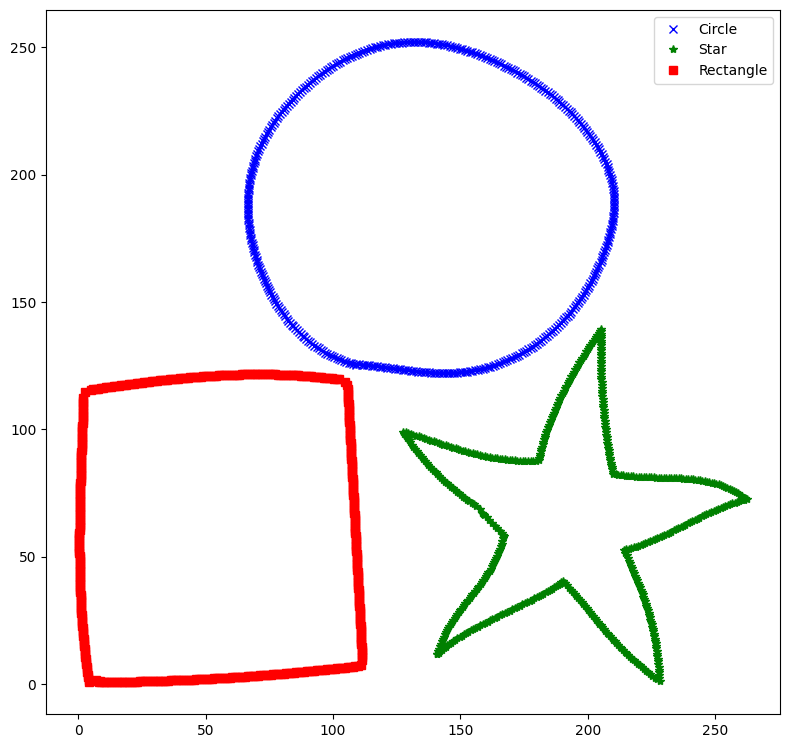

Coordinates written to shapes_coordinates.csv


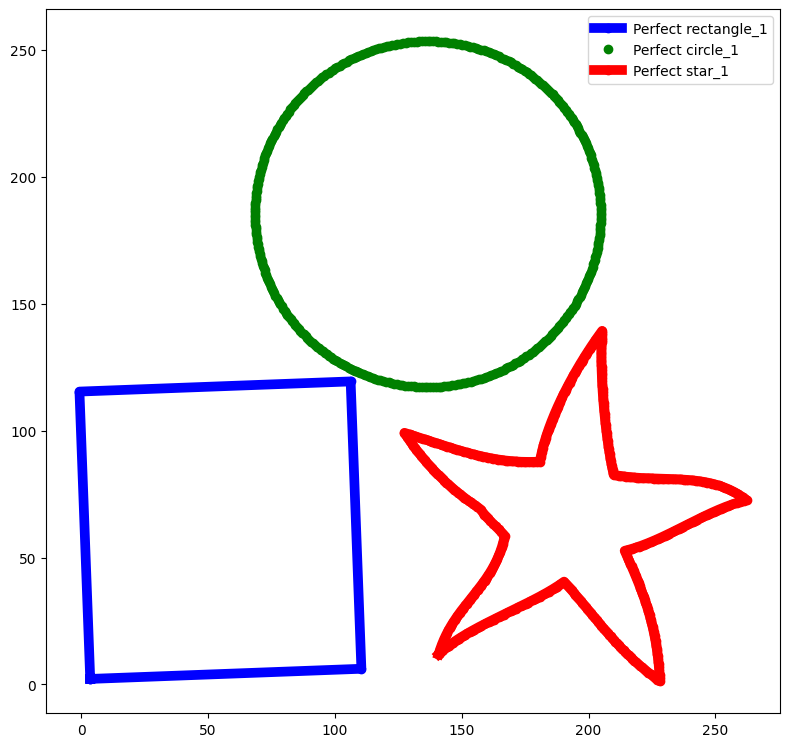

Total symmetries found :  8
Circle has infinite symmetries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from shapely.geometry import LineString
from scipy.ndimage import gaussian_filter1d
from itertools import combinations
from shapely.affinity import rotate,translate
from shapely.geometry import Polygon, MultiPoint

from scipy.optimize import least_squares
# Initialize lists for storing paths of different shapes
isLines = []
isCircle = {}
isRectangle = {}
isStar = {}
isEllipse = {}  # For ellipses
isRegularPolygon = {}  # For regular polygons
isGeneralCurve = []  # For general curves
isLshape=[]

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]  # Corrected slicing
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def is_approximate_line(XY, tolerance=14.0):
    if len(XY) < 3:
        return True

    x0, y0 = XY[0]
    x1, y1 = XY[-1]

    A = y1 - y0
    B = x0 - x1
    C = x1 * y0 - x0 * y1

    def distance_to_line(x, y):
        return abs(A * x + B * y + C) / np.sqrt(A**2 + B**2)

    for x, y in XY:
        if distance_to_line(x, y) > tolerance:
            return False

    return True

def is_approximate_circle(XY, tolerance=10.0, closing_tolerance=5.0):
    if len(XY) < 3:
        return False

    # Ensure the path is approximately closed
    if np.linalg.norm(XY[0] - XY[-1]) > closing_tolerance:
        return False

    # Estimate the circle center as the mean of the points
    center = np.mean(XY, axis=0)
    distances = np.linalg.norm(XY - center, axis=1)
    radius = np.mean(distances)

    # Check if all points lie within the tolerance distance from the mean radius
    if np.all(np.abs(distances - radius) < tolerance):
        return True

    return False

def calculate_angle(p1, p2, p3):
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    angle = np.arctan2(np.cross(v1, v2), np.dot(v1, v2))
    return np.degrees(np.abs(angle))

def is_right_angle(angle, tolerance):
    return 90 - tolerance <= angle <= 90 + tolerance

def is_approximate_rectangle(XY, tolerance=30.0, angle_tolerance=15.0):
    if len(XY) < 4:
        return False

    path_tuples = [tuple(p) for p in XY]

    if path_tuples[0] != path_tuples[-1]:
        path_tuples.append(path_tuples[0])

    line = LineString(path_tuples)
    simplified_line = line.simplify(tolerance)
    simplified_coords = list(simplified_line.coords)

    if len(simplified_coords) != 5:
        return False

    for i in range(1, len(simplified_coords) - 2):
        angle = calculate_angle(simplified_coords[i - 1], simplified_coords[i], simplified_coords[i + 1])
        if not is_right_angle(angle, angle_tolerance):
            return False

    # Check for parallel opposite sides
    for i in range(2):
        side1 = np.array(simplified_coords[i + 1]) - np.array(simplified_coords[i])
        side3 = np.array(simplified_coords[i + 3]) - np.array(simplified_coords[i + 2])
        if not np.allclose(side1, -side3, atol=tolerance):
            return False

    return True

def is_approximate_ellipse(XY, tolerance=10.0, closing_tolerance=5.0):
    if len(XY) < 5:  # Ellipses require at least 5 points for a meaningful fit
        return False

    # Ensure the path is approximately closed
    if np.linalg.norm(XY[0] - XY[-1]) > closing_tolerance:
        return False

    # Fit an ellipse to the points using PCA
    mean = np.mean(XY, axis=0)
    cov_matrix = np.cov(XY, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Major and minor axes lengths
    major_axis_length = 2 * np.sqrt(eigenvalues[1])
    minor_axis_length = 2 * np.sqrt(eigenvalues[0])

    # Check if the shape is close to a circle
    if np.abs(major_axis_length - minor_axis_length) < tolerance:
        return False  # It's more likely a circle

    return True

def is_approximate_regular_polygon(XY, tolerance=15.0, closing_tolerance=5.0):
    num_points = len(XY)
    if num_points < 3:  # A polygon must have at least 3 points
        return False

    # Ensure the path is approximately closed
    if np.linalg.norm(XY[0] - XY[-1]) > closing_tolerance:
        return False

    # Calculate the centroid of the polygon
    centroid = np.mean(XY, axis=0)

    # Calculate the distances from the centroid to each vertex
    distances = np.linalg.norm(XY - centroid, axis=1)

    # Check if all distances are within the specified tolerance
    if np.max(distances) - np.min(distances) > tolerance:
        return False

    # Calculate the angles between each adjacent vertex
    angles = []
    for i in range(num_points):
        p1 = XY[i]
        p2 = XY[(i + 1) % num_points]
        angle = np.arctan2(p2[1] - p1[1], p2[0] - p1[0])
        angles.append(angle)

    # Calculate the differences between adjacent angles
    angle_differences = np.diff(np.unwrap(angles))

    # Check if all angle differences are within the specified tolerance
    if np.max(angle_differences) - np.min(angle_differences) > np.radians(tolerance):
        return False

    return True

def is_approximate_general_curve(XY, tolerance=15.0):
    if len(XY) < 3:
        return True  # Too few points to determine, consider it a curve
    return True  # General curve doesn't need specific criteria

def is_approximate_star(XY, num_points=5, distance_tolerance=80.0, angle_tolerance=20.0, closing_tolerance=10.0, smooth_sigma=0.1, plot=False):
    if len(XY) < num_points * 2:
        print("Not enough points.")
        return False

    # Ensure the path is approximately closed
    if np.linalg.norm(XY[0] - XY[-1]) > closing_tolerance:
        return False

    # Compute the centroid of the points
    centroid = np.mean(XY, axis=0)

    # Compute distances from the centroid and apply smoothing
    distances = np.linalg.norm(XY - centroid, axis=1)
    smoothed_distances = gaussian_filter1d(distances, sigma=smooth_sigma)

    # Detect local maxima and minima on smoothed distances
    peaks = []
    valleys = []
    for i in range(1, len(smoothed_distances) - 1):
        if smoothed_distances[i] > smoothed_distances[i - 1] and smoothed_distances[i] > smoothed_distances[i + 1]:
            peaks.append(i)
        elif smoothed_distances[i] < smoothed_distances[i - 1] and smoothed_distances[i] < smoothed_distances[i + 1]:
            valleys.append(i)

    # Plotting for debugging
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(distances, label='Distances')
        plt.plot(smoothed_distances, label='Smoothed Distances')
        plt.scatter(peaks, smoothed_distances[peaks], color='red', label='Peaks')
        plt.scatter(valleys, smoothed_distances[valleys], color='blue', label='Valleys')
        plt.legend()
        plt.title("Peak and Valley Detection")
        plt.show()


    # Ensure there are enough peaks and valleys
    if abs(len(peaks) - len(valleys)) == 1:
        return True

    # Ensure peaks and valleys alternate
    def check_alternation(peaks, valleys):
        combined = sorted(peaks + valleys)
        is_peak = smoothed_distances[combined[0]] > smoothed_distances[combined[1]]
        for i in range(1, len(combined)):
            if (smoothed_distances[combined[i]] > smoothed_distances[combined[i - 1]]) != is_peak:
                return False
            is_peak = not is_peak
        return True

    if not check_alternation(peaks, valleys):
        print("Peaks and valleys do not alternate.")
        return False

    # Ensure that the distances of peaks and valleys from the centroid are within tolerance
    peak_distances = distances[peaks]
    valley_distances = distances[valleys]

    if np.ptp(peak_distances) > distance_tolerance or np.ptp(valley_distances) > distance_tolerance:
        print("Distance tolerance exceeded.")
        return False

    # Ensure the angles between peaks and valleys are consistent
    angles = []
    for i in range(min(len(peaks), len(valleys))):
        p1 = XY[peaks[i]]
        p2 = centroid
        p3 = XY[valleys[i]]
        angle = calculate_angle(p1, p2, p3)
        angles.append(angle)

    mean_angle = np.mean(angles)
    if np.any(np.abs(angles - mean_angle) > angle_tolerance):
        print("Angle tolerance exceeded.")
        return False

    if len(peaks) < num_points or len(valleys) < num_points:
        print("Not enough peaks or valleys.")
        return False

    return True


def is_l_shape(XY, tolerance=10.0):
    if len(XY) < 3:
        return False

    for i in range(1, len(XY) - 1):
        p1 = XY[i - 1]
        p2 = XY[i]
        p3 = XY[i + 1]

        vec1 = p2 - p1
        vec2 = p3 - p2

        angle = np.degrees(np.arccos(np.clip(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)), -1.0, 1.0)))


        if  60<= angle <= 100:
            return True

    return False


def is_approximate_circle_from_combined_curves(XYs, tolerance=10.0, closing_tolerance=5.0):
    combined_XY = np.concatenate(XYs, axis=0)
    return is_approximate_circle(combined_XY, tolerance, closing_tolerance)

def check_for_circular_combinations(general_curves):
    circle_set = set()
    i = 1
    used_curves = set()
    for n in [4]:
        combinations = itertools.permutations(general_curves, n)
        for combo in combinations:
            if is_approximate_circle_from_combined_curves(combo):
                # Convert each path in the combination to a sorted tuple of tuples
                combo_tuple = tuple(sorted(tuple(map(tuple, path)) for path in combo))
                if combo_tuple not in circle_set:
                    circle_set.add(combo_tuple)
                    # Store in dictionary as a list of numpy arrays
                    isCircle[i] = [np.array(path) for path in combo]
                    # Update used_curves by converting numpy arrays to tuples
                    used_curves.update(tuple(map(tuple, path)) for path in combo)
                    i += 1

    # Create a set of used curves as tuples
    used_curves_set = set(tuple(map(tuple, curve)) for curve in used_curves)

    # Remove used curves from isGeneralCurve
    isGeneralCurve[:] = [curve for curve in isGeneralCurve if tuple(map(tuple, curve)) not in used_curves_set]


def is_approximate_rectangle_from_combined_lines(XYs):
    combined_XY = np.concatenate(XYs, axis=0)  # Combine all line coordinates
    return is_approximate_rectangle(combined_XY)

def check_for_rectangle_combinations(isLines):
    rectangle_set = set()
    i = 1
    used_lines = set()

    for n in [4]:
        combinations_list = itertools.permutations(isLines, n)
        for combo in combinations_list:
            if is_approximate_rectangle_from_combined_lines(combo):
                combo_tuple = tuple(sorted(tuple(map(tuple, path)) for path in combo))
                if combo_tuple not in rectangle_set:
                    rectangle_set.add(combo_tuple)
                    # Store in dictionary as a list of numpy arrays
                    isRectangle[i] = [np.array(path) for path in combo]
                    # Update used_lines by converting numpy arrays to tuples
                    used_lines.update(tuple(map(tuple, path)) for path in combo)
                    i += 1

    # Create a set of used curves as tuples
    used_lines_set = set(tuple(map(tuple, line)) for line in used_lines)

    # Remove used lines from isLines
    isLines[:] = [line for line in isLines if tuple(map(tuple, line)) not in used_lines_set]



def break_l_shape_into_lines(XY):
    if len(XY) < 3:
        return

    for i in range(1, len(XY) - 1):
        p1 = XY[i - 1]
        p2 = XY[i]
        p3 = XY[i + 1]

        vec1 = p2 - p1
        vec2 = p3 - p2

        angle = np.degrees(np.arccos(np.clip(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)), -1.0, 1.0)))

        if 60 <= angle <= 100:
            isLines.append(np.array([XY[0], p2]))
            isLines.append(np.array([p2, XY[len(XY)-1]]))
            break  # Exit after breaking the L-shape into lines



def classify_path(XY):
    if is_approximate_line(XY):
        isLines.append(XY)
    elif is_approximate_circle(XY):
        key = f"circle_{len(isCircle) + 1}"
        if key not in isCircle:
            isCircle[key] = []
        isCircle[key].append(XY)
    elif is_approximate_rectangle(XY):
        key = f"rectangle_{len(isRectangle) + 1}"
        if key not in isRectangle:
            isRectangle[key] = []
        isRectangle[key].append(XY)
    elif is_approximate_star(XY):
        key = f"star_{len(isStar) + 1}"
        if key not in isStar:
            isStar[key] = []
        isStar[key].append(XY)
    elif is_approximate_ellipse(XY):
        key = f"ellipse_{len(isEllipse) + 1}"
        if key not in isEllipse:
            isEllipse[key] = []
        isEllipse[key].append(XY)
    elif is_l_shape(XY):
        break_l_shape_into_lines(XY)
    elif is_approximate_regular_polygon(XY):
        key = f"polygon_{len(isRegularPolygon) + 1}"
        if key not in isRegularPolygon:
            isRegularPolygon[key] = []
        isRegularPolygon[key].append(XY)
    else:
        isGeneralCurve.append(XY)

def plot(path_XYs, new_rectangles=None, new_circles=None):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    # Plot original paths
    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

            if is_approximate_line(XY):
                ax.plot(XY[:, 0], XY[:, 1], 'o', c=c, label='Line')
            elif is_approximate_circle(XY):
                ax.plot(XY[:, 0], XY[:, 1], 'x', c=c, label='Circle')
            elif is_approximate_rectangle(XY):
                ax.plot(XY[:, 0], XY[:, 1], 's', c=c, label='Rectangle')
            elif is_approximate_ellipse(XY):
                ax.plot(XY[:, 0], XY[:, 1], 'D', c=c, label='Ellipse')
            elif is_approximate_star(XY):
                ax.plot(XY[:, 0], XY[:, 1], '*', c=c, label='Star')
            elif is_approximate_regular_polygon(XY):
                ax.plot(XY[:, 0], XY[:, 1], '^', c=c, label='Regular Polygon')
            elif is_l_shape(XY):
                ax.plot(XY[:, 0], XY[:, 1], 'o', c=c, label='L-shape')
            elif is_approximate_general_curve(XY):
                ax.plot(XY[:, 0], XY[:, 1], 'p', c=c, label='General Curve')


    # Set aspect ratio to be equal
    ax.set_aspect('equal')
    # Remove duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.show()



def plotRegularized():
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    i = 0

    if isLines is not None:
        for XY in isLines:
            c = colours[i % len(colours)]
            ax.plot(XY[:, 0], XY[:, 1], 'o-', c=c, linewidth=7)
            i += 1

    if isGeneralCurve is not None:
        for XY in isGeneralCurve:
            c = colours[i % len(colours)]
            ax.plot(XY[:, 0], XY[:, 1], 'o-', c=c, linewidth=7)
            i += 1

    if isRectangle is not None:
        for key, rectangles in isRectangle.items():
            for XY in rectangles:
                c = colours[i % len(colours)]
                ax.plot(XY[:, 0], XY[:, 1], 'o-', c=c, label=f'Perfect {key}', linewidth=7)
                i += 1

    if isCircle is not None:
        for key, circles in isCircle.items():
            for XY in circles:
                c = colours[i % len(colours)]
                ax.plot(XY[:, 0], XY[:, 1], 'o', c=c, label=f'Perfect {key}', linewidth=10)
                i += 1

    if isEllipse is not None:
        for key, ellipses in isEllipse.items():
            for XY in ellipses:
                c = colours[i % len(colours)]
                ax.plot(XY[:, 0], XY[:, 1], 'o-', c=c, label=f'Perfect {key}', linewidth=7)
                i += 1

    if isStar is not None:
        for key, stars in isStar.items():
            for XY in stars:
                c = colours[i % len(colours)]
                ax.plot(XY[:, 0], XY[:, 1], 'o-', c=c, label=f'Perfect {key}', linewidth=7)
                i += 1

    ax.set_aspect('equal')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.show()


def make_perfect_circle(circle):
    combined_XY = np.concatenate(circle, axis=0)
    center = np.mean(combined_XY, axis=0)
    radius = np.mean(np.linalg.norm(combined_XY - center, axis=1))

    perfect_circle = []
    for XY in circle:
        angles = np.arctan2(XY[:, 1] - center[1], XY[:, 0] - center[0])
        perfect_XY = np.column_stack((center[0] + radius * np.cos(angles),
                                      center[1] + radius * np.sin(angles)))
        perfect_circle.append(perfect_XY)

    return perfect_circle
import numpy as np
from scipy.optimize import least_squares

def make_perfect_rectangle_least_squares(rectangle, shrink_factor=1.33):
    # Combine all points from the rectangle's segments
    combined_points = np.vstack(rectangle)

    def rectangle_error(params):
        cx, cy, width, height, angle = params
        # Create a perfect rectangle
        perfect_rect = np.array([
            [-width/2, -height/2],
            [width/2, -height/2],
            [width/2, height/2],
            [-width/2, height/2]
        ])

        # Rotate the rectangle
        rot_matrix = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ])
        rotated_rect = np.dot(perfect_rect, rot_matrix.T)

        # Translate the rectangle
        translated_rect = rotated_rect + [cx, cy]

        # Calculate the error
        errors = []
        for point in combined_points:
            distances = np.linalg.norm(translated_rect - point, axis=1)
            errors.append(np.min(distances))
        return errors

    # Initial guess
    x_min, y_min = np.min(combined_points, axis=0)
    x_max, y_max = np.max(combined_points, axis=0)
    initial_guess = [
        (x_min + x_max) / 2,  # center x
        (y_min + y_max) / 2,  # center y
        x_max - x_min,        # width
        y_max - y_min,        # height
        0                     # angle
    ]

    # Optimize
    result = least_squares(rectangle_error, initial_guess)

    # Extract the optimized parameters
    cx, cy, width, height, angle = result.x

    # Apply the shrink factor to make the rectangle slightly smaller
    width *= shrink_factor
    height *= shrink_factor

    # Create the perfect rectangle
    perfect_rect = np.array([
        [-width/2, -height/2],
        [width/2, -height/2],
        [width/2, height/2],
        [-width/2, height/2],
        [-width/2, -height/2]  # Close the rectangle
    ])

    # Rotate and translate
    rot_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    rotated_rect = np.dot(perfect_rect, rot_matrix.T)
    final_rect = rotated_rect + [cx, cy]

    # Split the perfect rectangle into segments matching the original input
    perfect_segments = []
    start_idx = 0
    for seg in rectangle:
        end_idx = start_idx + len(seg)
        perfect_segments.append(final_rect[start_idx:end_idx])
        start_idx = end_idx - 1  # Overlap end points

    return perfect_segments




#FUNCTIONS TO MAKE IDENTIFIED SHAPES PERFECT
import numpy as np

def make_perfect_line(line):
    """
    Adjusts the given line to be perfectly straight.

    Args:
    - line (np.ndarray): A 2D array of points representing a line.
      The shape of the array should be (n, 2) where n is the number of points.

    Returns:
    - np.ndarray: A new 2D array where all points lie on the straight line between the first and last points.
    """
    if len(line) < 2:
        return line  # No change for lines with less than 2 points

    start_point = line[0]
    end_point = line[-1]

    # Calculate the direction vector of the line
    direction_vector = end_point - start_point

    # Normalize the direction vector
    direction_vector = direction_vector / np.linalg.norm(direction_vector)

    # Calculate the distances of each point from the start point along the line direction
    distances = np.dot(line - start_point, direction_vector)

    # Generate the new points on the perfect line
    perfect_line = np.outer(distances, direction_vector) + start_point

    return perfect_line






import csv

def write_coordinates_to_csv(filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write headers
        writer.writerow(['Shape', 'Group', 'Point Index', 'X', 'Y'])

        # Write line coordinates
        for i, line in enumerate(isLines):
            for point_index, point in enumerate(line):
                writer.writerow(['Line', f'Line_{i+1}', point_index+1, point[0], point[1]])

        # Write circle coordinates
        for key, circles in isCircle.items():
            for i, circle in enumerate(circles):
                for point_index, point in enumerate(circle):
                    writer.writerow(['Circle', f'{key}_{i+1}', point_index+1, point[0], point[1]])

        # Write rectangle coordinates
        for key, rectangles in isRectangle.items():
            for i, rectangle in enumerate(rectangles):
                for point_index, point in enumerate(rectangle):
                    writer.writerow(['Rectangle', f'{key}_{i+1}', point_index+1, point[0], point[1]])

        # Write star coordinates
        for key, stars in isStar.items():
            for i, star in enumerate(stars):
                for point_index, point in enumerate(star):
                    writer.writerow(['Star', f'{key}_{i+1}', point_index+1, point[0], point[1]])

        # Write ellipse coordinates
        for key, ellipses in isEllipse.items():
            for i, ellipse in enumerate(ellipses):
                for point_index, point in enumerate(ellipse):
                    writer.writerow(['Ellipse', f'{key}_{i+1}', point_index+1, point[0], point[1]])

        # Write regular polygon coordinates
        for key, polygons in isRegularPolygon.items():
            for i, polygon in enumerate(polygons):
                for point_index, point in enumerate(polygon):
                    writer.writerow(['Regular Polygon', f'{key}_{i+1}', point_index+1, point[0], point[1]])

        # Write general curve coordinates
        for i, curve in enumerate(isGeneralCurve):
            for point_index, point in enumerate(curve):
                writer.writerow(['General Curve', f'Curve_{i+1}', point_index+1, point[0], point[1]])

        # Write L-shape coordinates
        for i, l_shape in enumerate(isLshape):
            for point_index, point in enumerate(l_shape):
                writer.writerow(['L-Shape', f'Lshape_{i+1}', point_index+1, point[0], point[1]])

    print(f"Coordinates written to {filename}")




csv_path = '/content/drive/MyDrive/Colab Notebooks/problems/isolated.csv'  # Update with your CSV file path
path_XYs = read_csv(csv_path)

for XYs in path_XYs:
    for XY in XYs:
        classify_path(XY)

# Usage example

if len(isLines) > 10:
    for i in range(len(isLines)):
        isLines[i] = make_perfect_line(isLines[i])

else:
  check_for_rectangle_combinations(isLines)


check_for_circular_combinations(isGeneralCurve)


for key in isCircle:
    isCircle[key] = make_perfect_circle(isCircle[key])

for key in isRectangle:
    isRectangle[key] = make_perfect_rectangle_least_squares(isRectangle[key])



plot(path_XYs)
write_coordinates_to_csv('shapes_coordinates.csv')

plotRegularized()
totalSymmetries = len(isStar)*5 + len(isRectangle)*3 + len(isLines)*1 + len(isEllipse)*2
print("Total symmetries found : " , totalSymmetries)
if(len(isCircle)!=0):
  print("Circle has infinite symmetries")
